# Model Comparison - ArXiv QA Test Results

This notebook compares the performance of different models on the `vidore_arxivqa_test_subsampled` dataset by analyzing their evaluation metrics.

In [15]:
import os
import json
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for our plots
plt.style.use('ggplot')
sns.set_palette("colorblind")
plt.rcParams['figure.figsize'] = [12, 8]

## Load the metrics files for all models

In [16]:
# Define the results directory
results_dir = "./results/"

# Find all arxivqa_test_subsampled_metrics.json files
arxivqa_files = []
for root, dirs, files in os.walk(results_dir):
    for file in files:
        if file == "vidore_arxivqa_test_subsampled_metrics.json":
            arxivqa_files.append(os.path.join(root, file))

print(f"Found {len(arxivqa_files)} model result files for ArXiv QA test.")

Found 4 model result files for ArXiv QA test.


In [17]:
# Function to extract model name from file path
def get_model_name(file_path):
    # Extract the model directory name
    parts = file_path.split('/')
    model_dir = [p for p in parts if p != 'results' and 'vidore_arxivqa_test' not in p][-1]
    return model_dir

# Load all the metrics into a dictionary
model_metrics = {}

for file_path in arxivqa_files:
    model_name = get_model_name(file_path)
    
    with open(file_path, 'r') as f:
        data = json.load(f)
        
    # Extract the metrics we want to compare
    metrics = data['metrics']['vidore/arxivqa_test_subsampled']
    model_metrics[model_name] = metrics
    
print(f"Loaded metrics for {len(model_metrics)} models.")
print("Models:")
for model in model_metrics.keys():
    print(f"- {model}")

Loaded metrics for 4 models.
Models:
- blip_Salesforce_blip-vqa-base
- clip_openai_clip-vit-base-patch32
- llava-interleave_llava-hf_llava-interleave-qwen-0.5b-hf
- vit_google_vit-base-patch16-224-in21k


## Extract and organize key metrics for comparison

In [18]:
# Define the metrics we want to compare
metric_types = ['ndcg', 'map', 'recall', 'precision']
k_values = [1, 3, 5, 10, 20, 50, 100]

# Create a pandas DataFrame to hold all metrics for easy comparison
all_metrics = []

for model_name, metrics in model_metrics.items():
    for metric_type in metric_types:
        for k in k_values:
            metric_key = f"{metric_type}_at_{k}"
            if metric_key in metrics:
                all_metrics.append({
                    'Model': model_name,
                    'Metric': metric_type,
                    'k': k,
                    'Value': metrics[metric_key]
                })

metrics_df = pd.DataFrame(all_metrics)
metrics_df.head(10)

,Model,Metric,k,Value
0,blip_Salesforce_blip-vqa-base,ndcg,1,0.00200
1,blip_Salesforce_blip-vqa-base,ndcg,3,0.00452
2,blip_Salesforce_blip-vqa-base,ndcg,5,0.00539
3,blip_Salesforce_blip-vqa-base,ndcg,10,0.00994
4,blip_Salesforce_blip-vqa-base,ndcg,20,0.01480
5,blip_Salesforce_blip-vqa-base,ndcg,50,0.02583
6,blip_Salesforce_blip-vqa-base,ndcg,100,0.04472
7,blip_Salesforce_blip-vqa-base,map,1,0.00200
8,blip_Salesforce_blip-vqa-base,map,3,0.00400
9,blip_Salesforce_blip-vqa-base,map,5,0.00450


## Visualize the results

In [24]:
# Function to plot metrics by k value
def plot_metric(df, metric_name, save_path=None):
    plt.figure(figsize=(12, 6), dpi=300)
    
    # Filter for the specific metric
    metric_df = df[df['Metric'] == metric_name]
    
    # Create line plot
    sns.lineplot(data=metric_df, x='k', y='Value', hue='Model', marker='o', markersize=8)
    
    plt.title(f'{metric_name.upper()} at k for different models')
    plt.xlabel('k (cutoff)')
    plt.ylabel(f'{metric_name.upper()} Value')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()

    if save_path:
        plt.savefig(os.path.join(save_path, metric_name + ".png"), dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")
    
    plt.show()

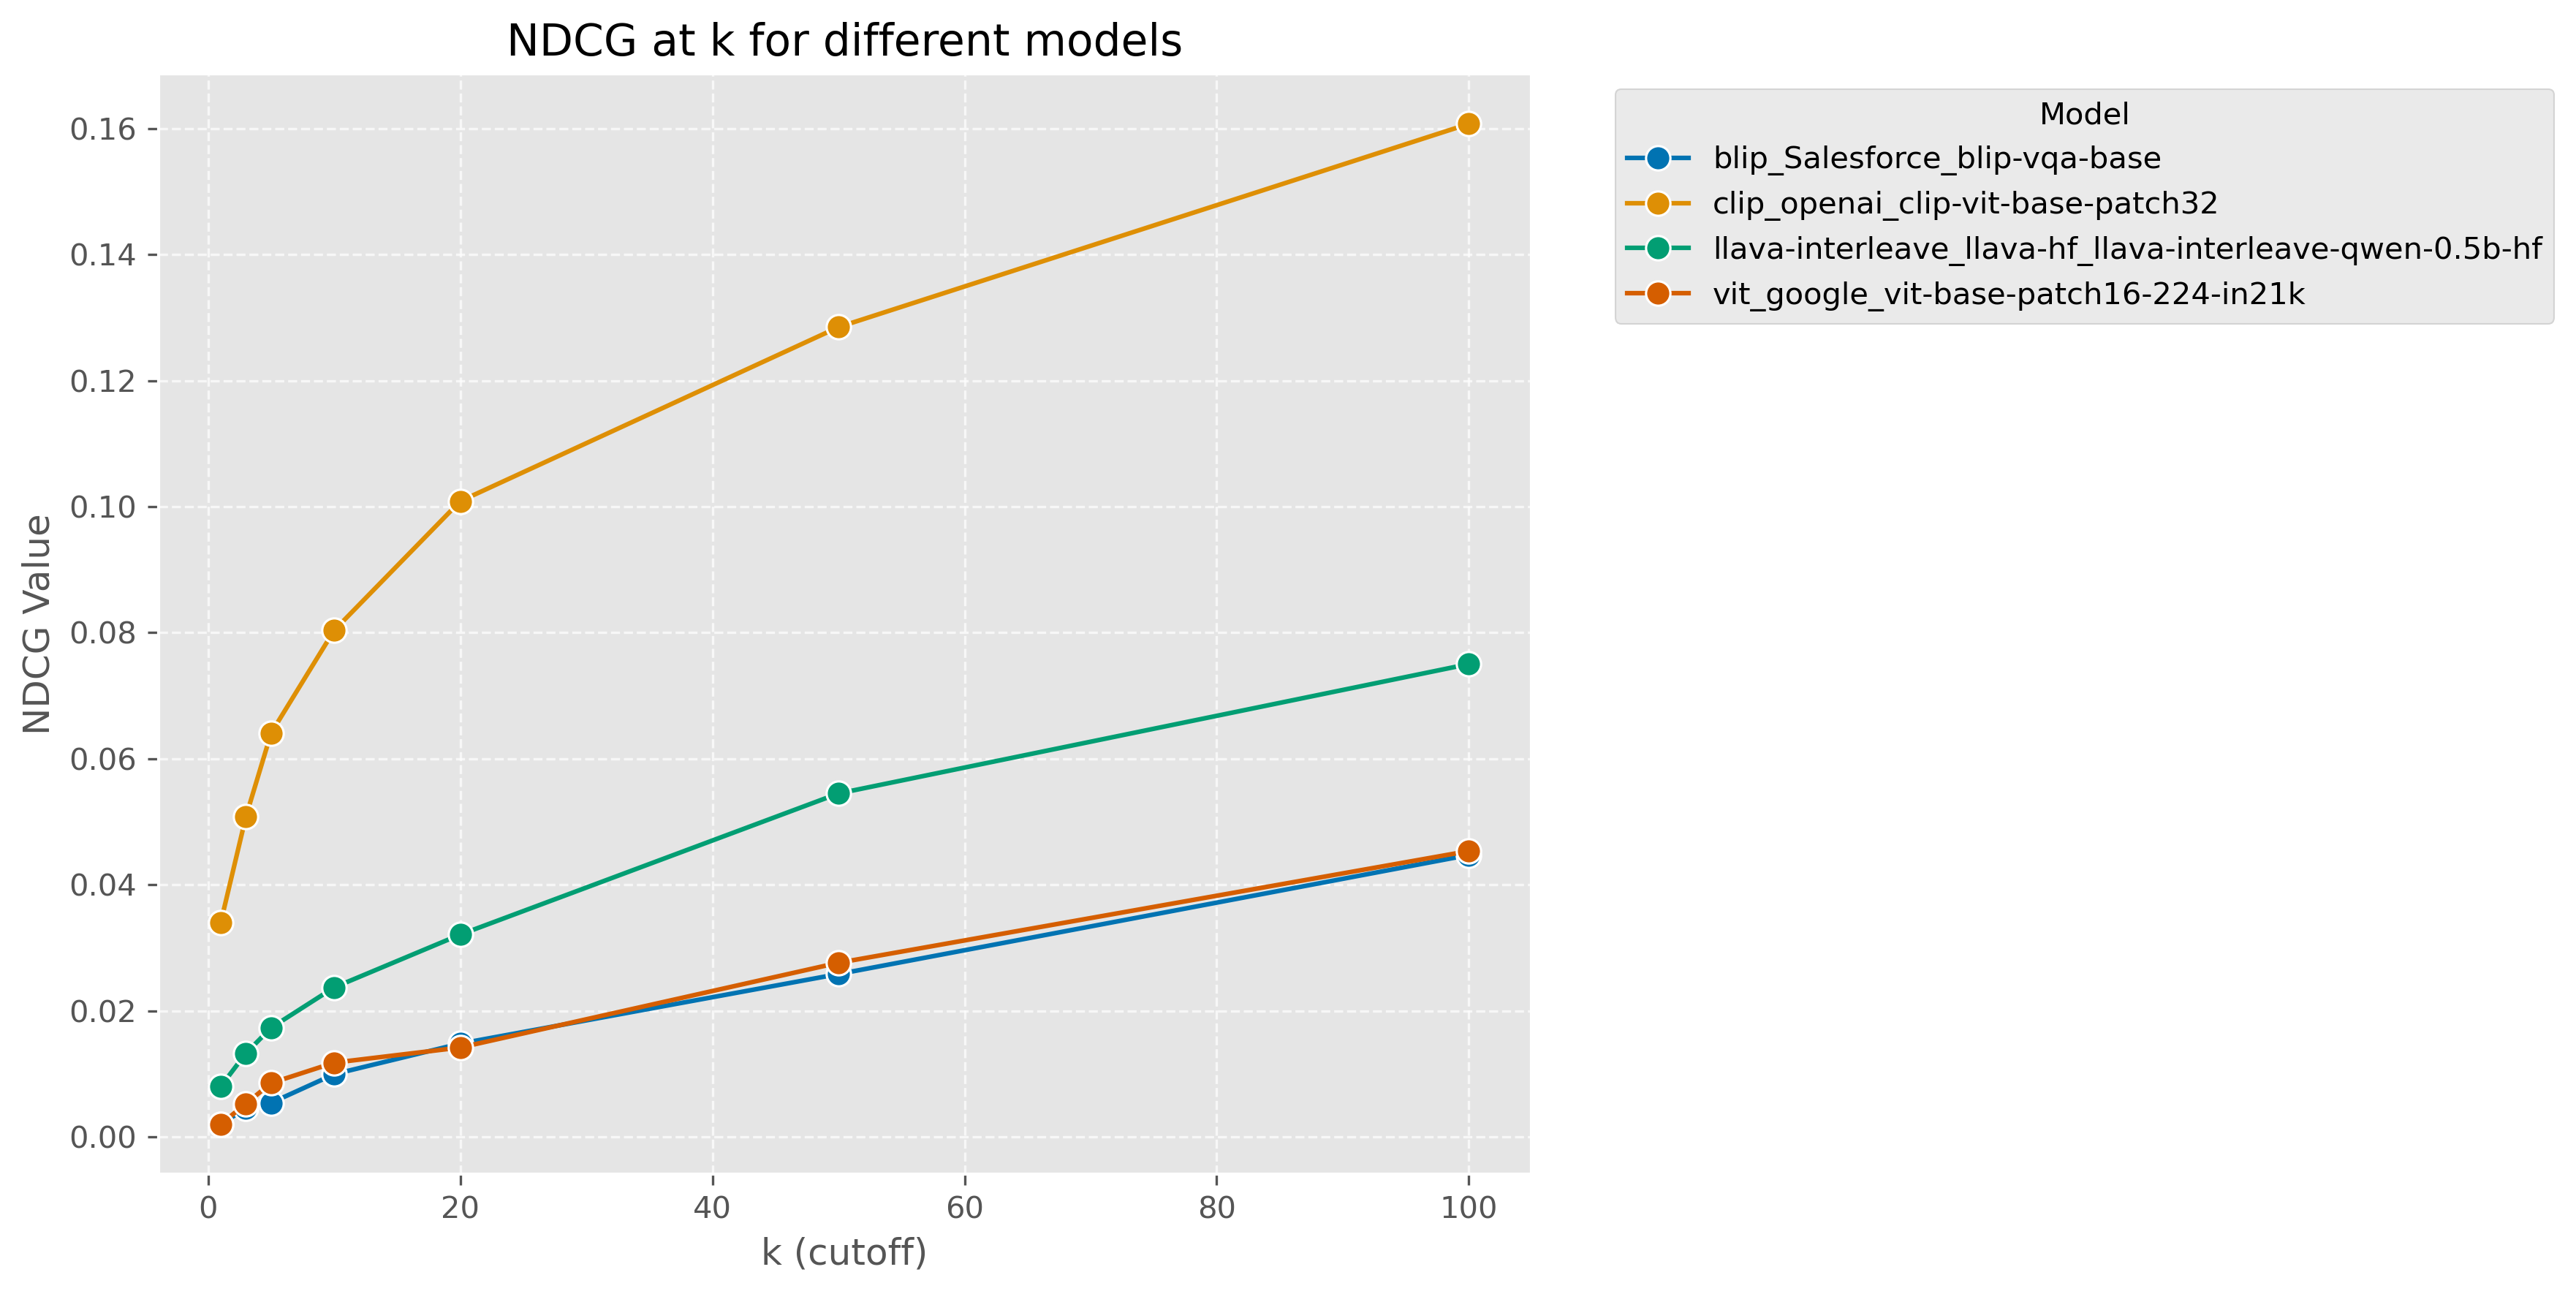

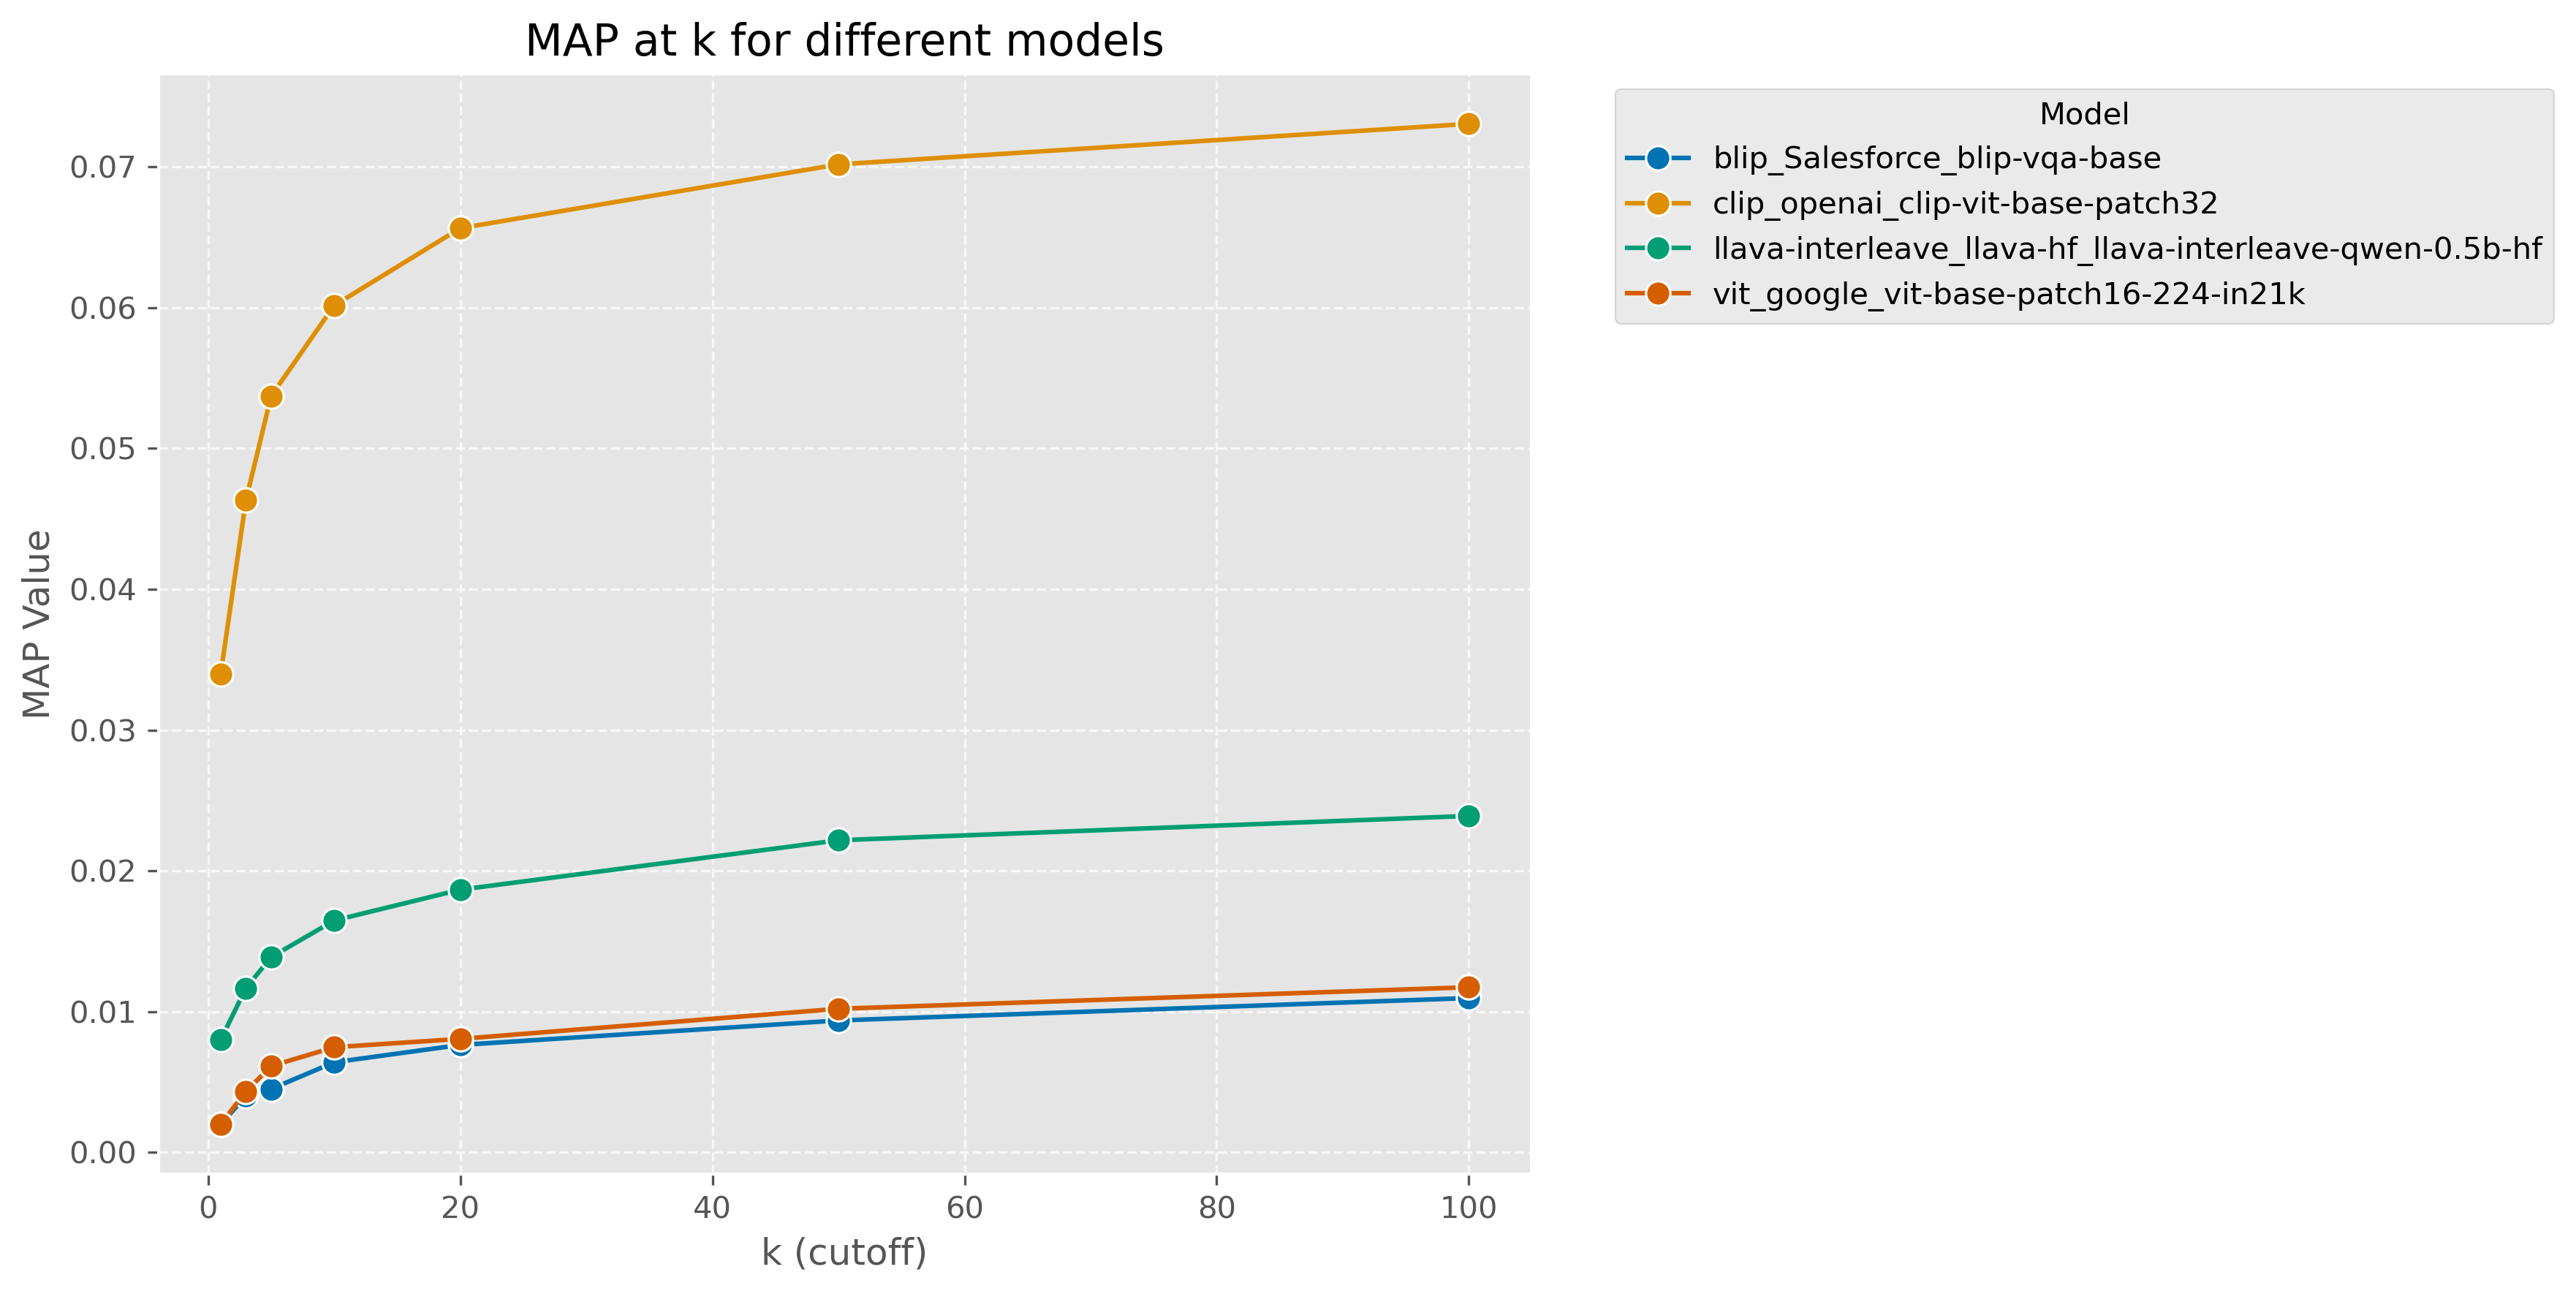

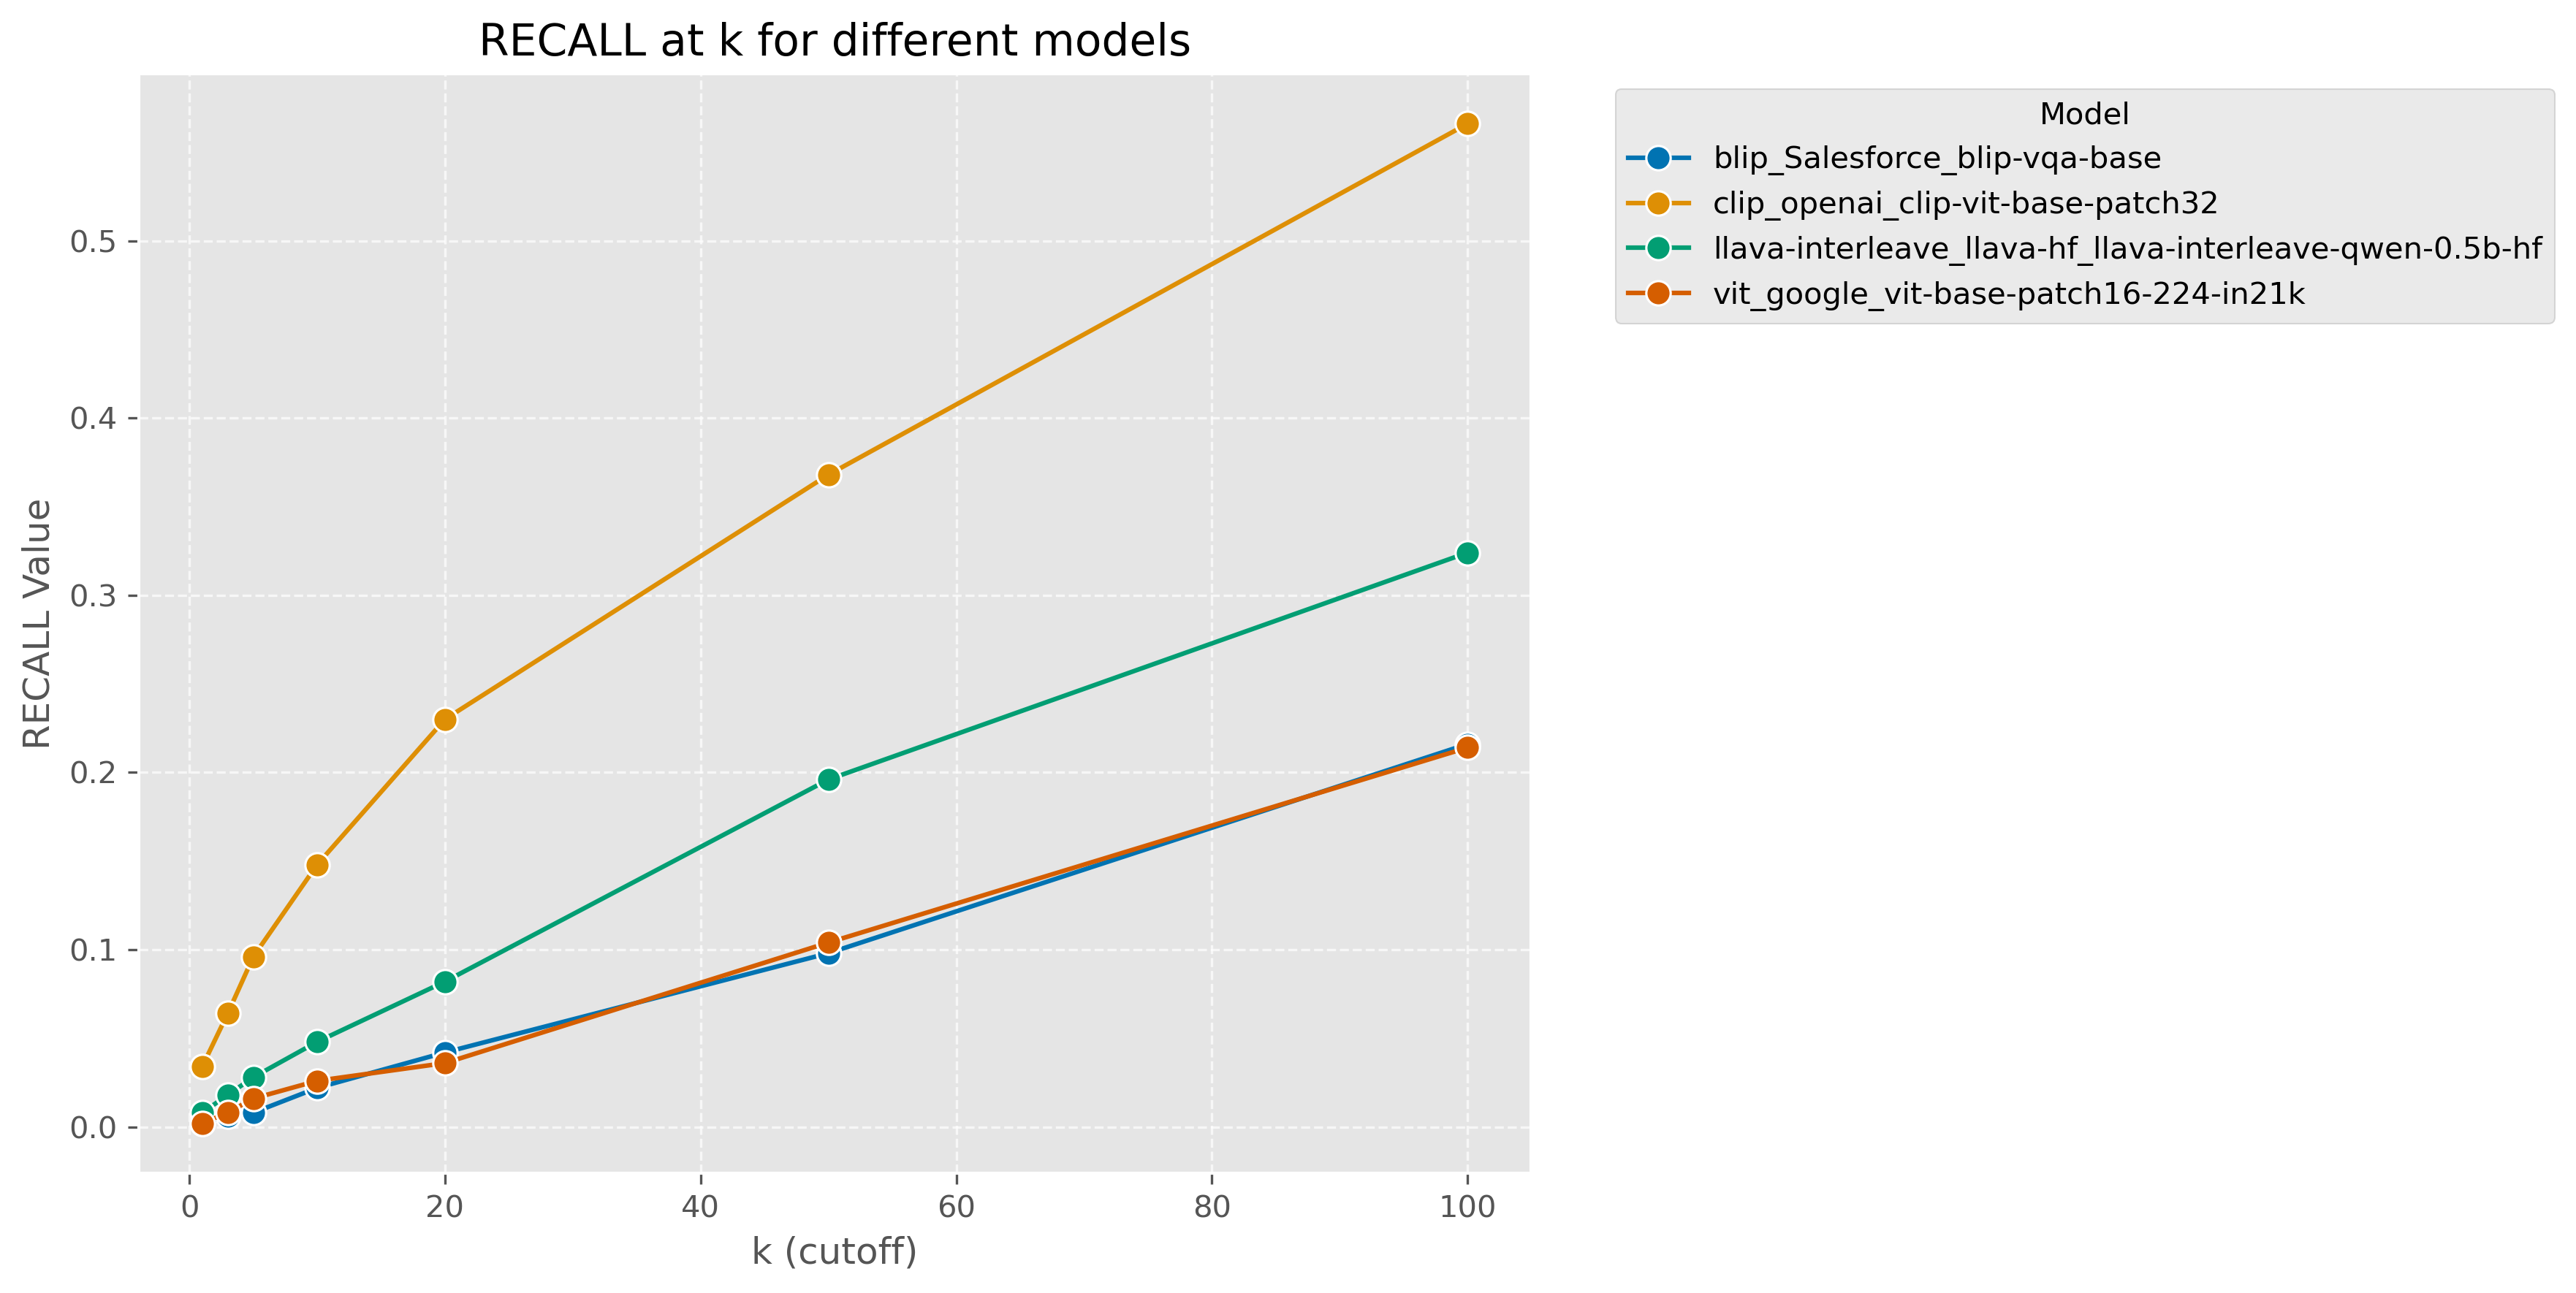

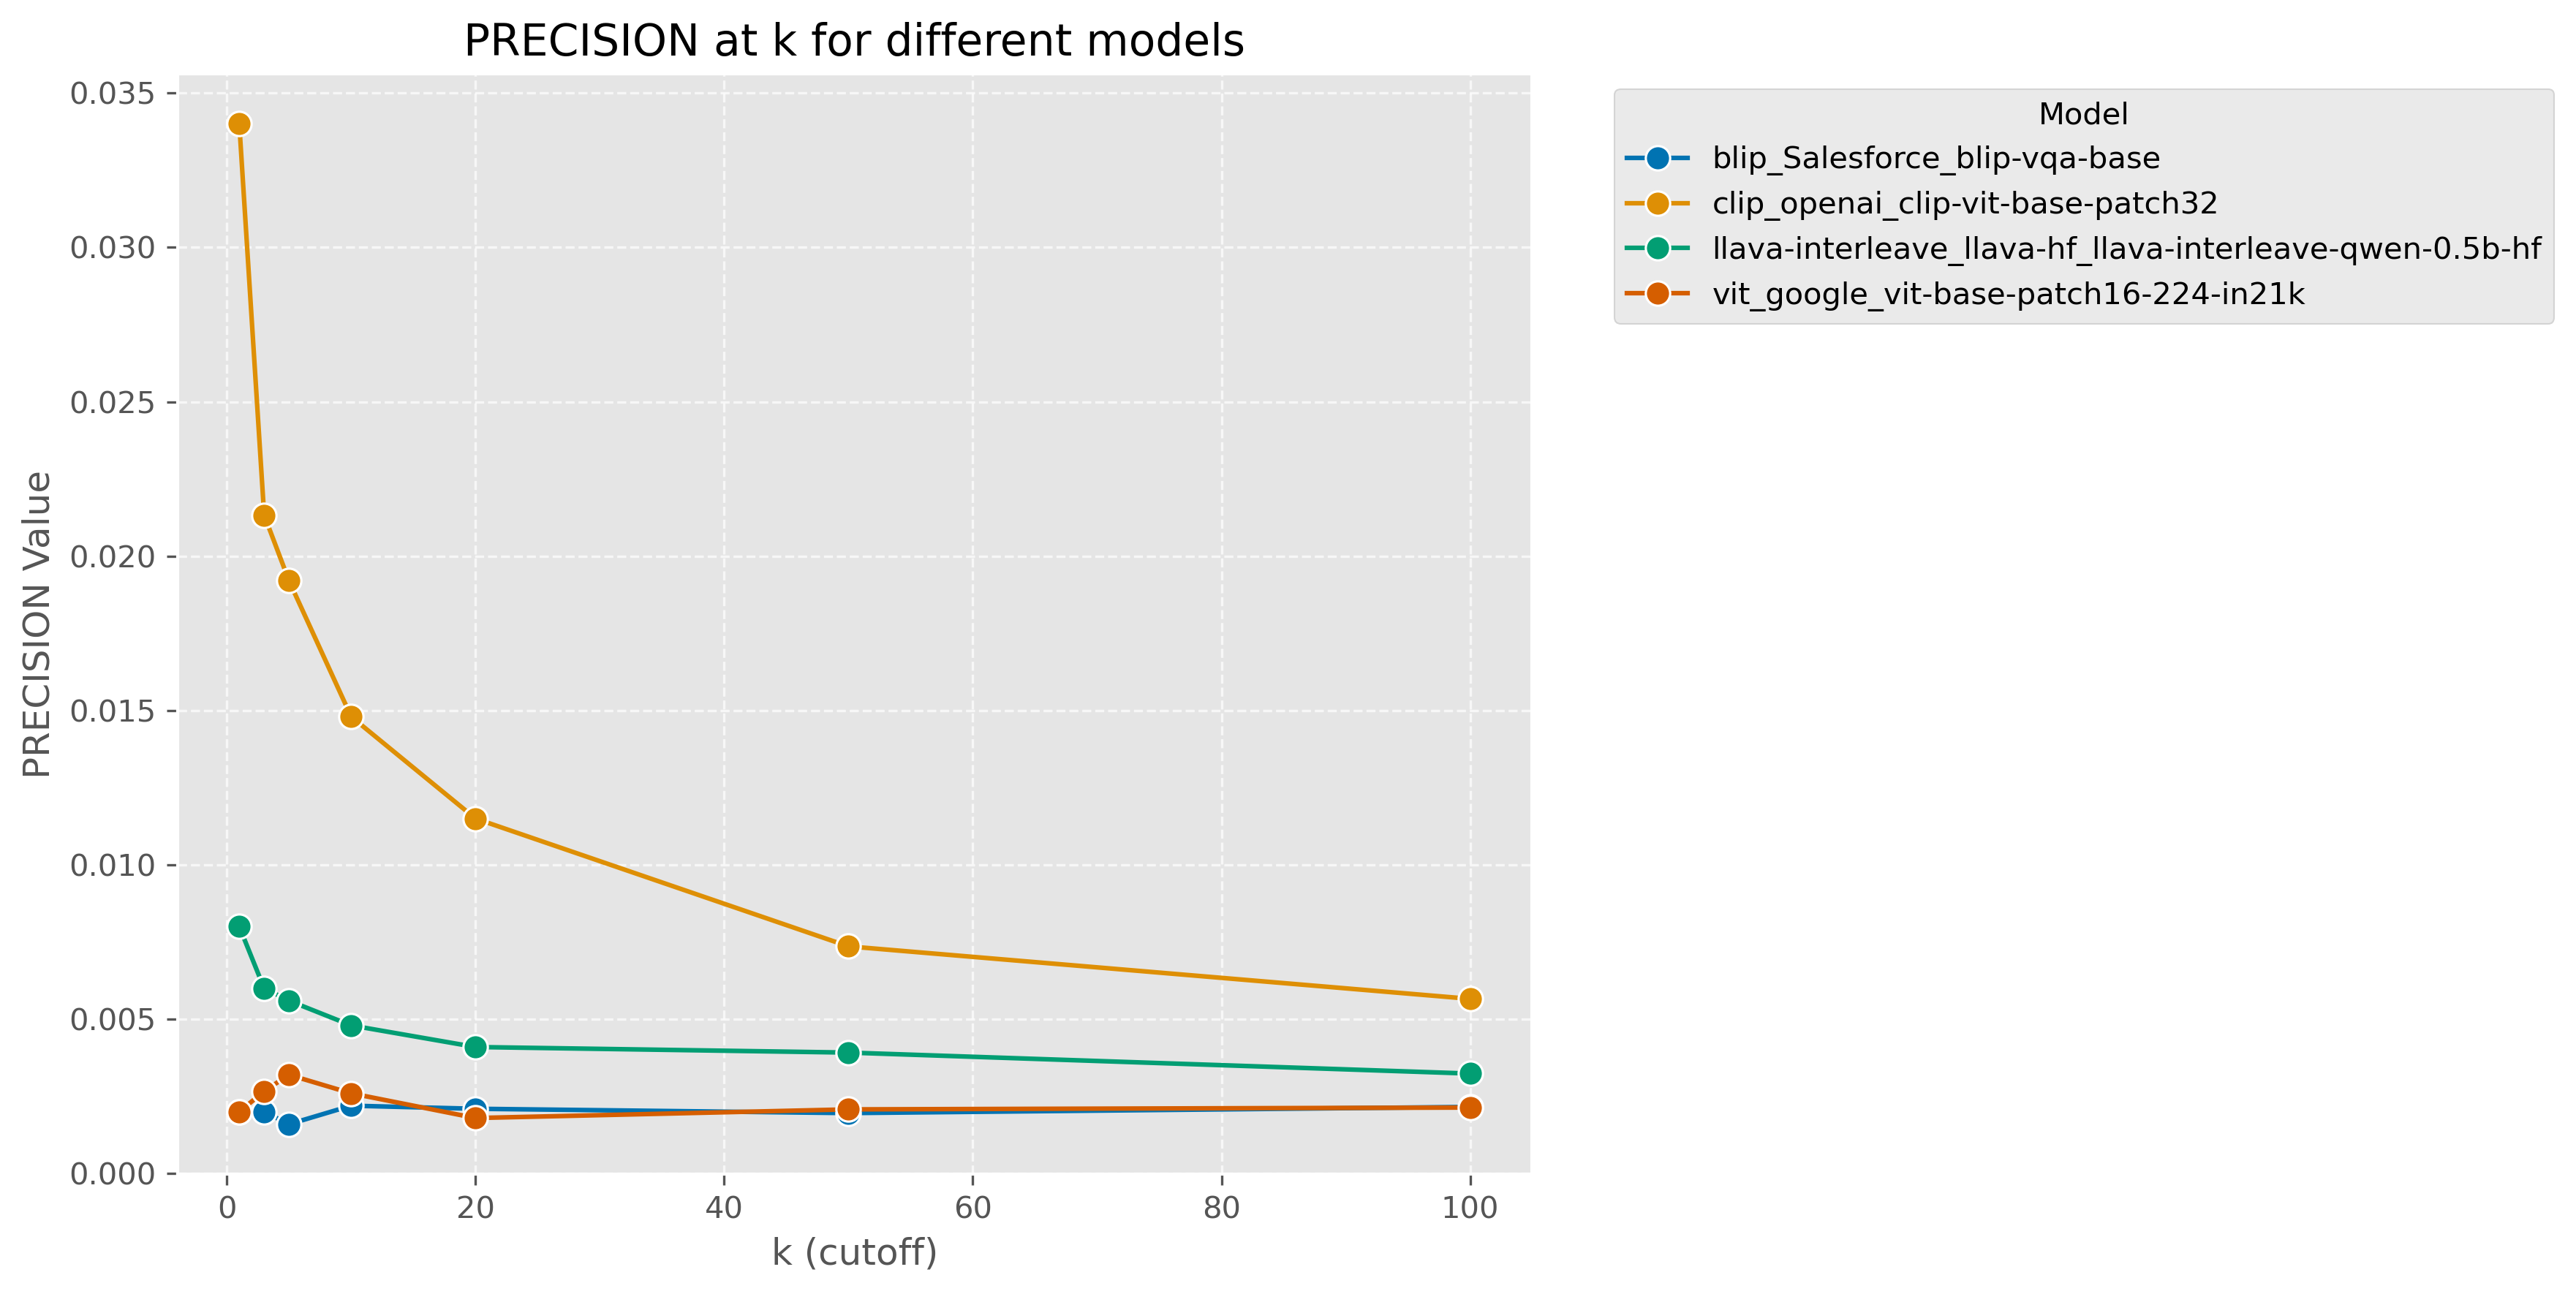

In [37]:
# Plot each metric type
os.makedirs("./figs", exist_ok=True)
for metric in metric_types:
    plot_metric(metrics_df, metric)

## Compare performance at specific cutoffs

In [35]:
# Function to create a bar chart comparing all models at a specific k value
def compare_at_k(df, k_value):
    plt.figure(figsize=(14, 10), dpi=300)
    
    # Filter for the specific k value
    k_df = df[df['k'] == k_value]
    
    # Create bar chart
    ax = sns.barplot(data=k_df, x='Model', y='Value', hue='Metric')

    plt.title(f'Metrics at k={k_value} for all models')
    plt.xlabel('Model')
    plt.ylabel('Metric Value')
    plt.xticks(rotation=10, ha='center')
    plt.legend(title='Metric')
    plt.grid(True, axis='y', linestyle='--', alpha=0.7)
    
    # Adjust layout
    plt.tight_layout()
    plt.show()

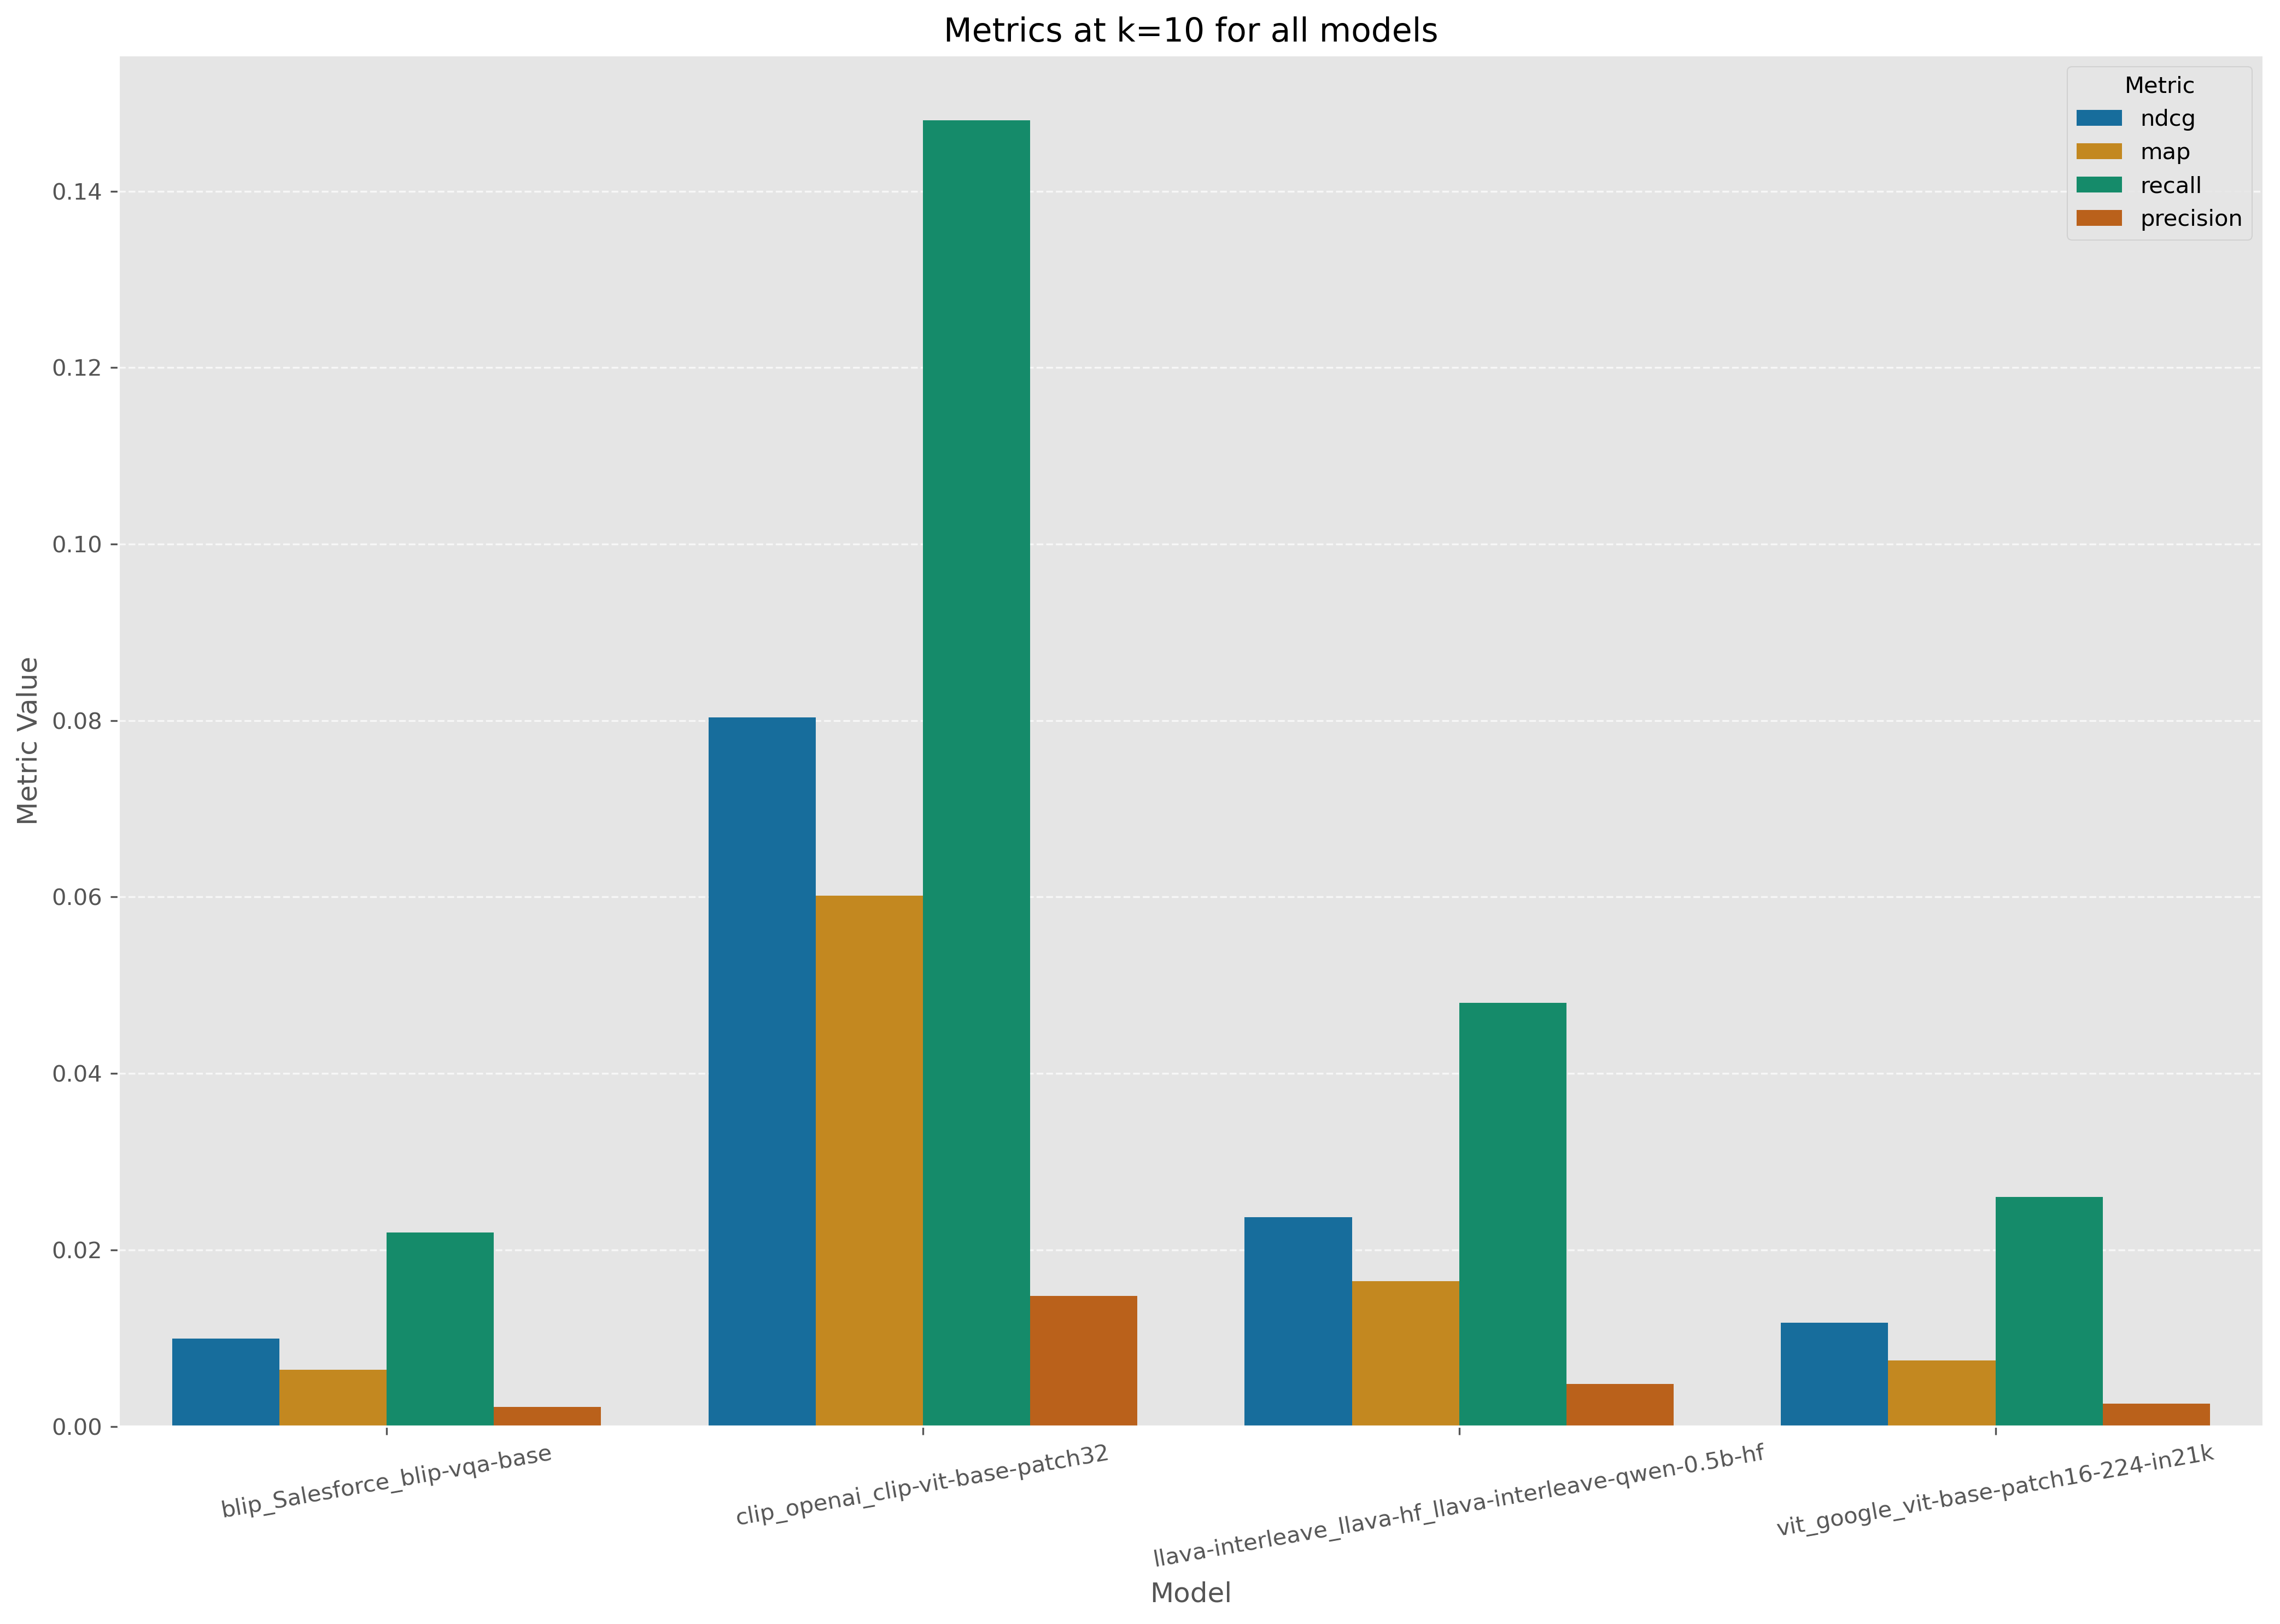

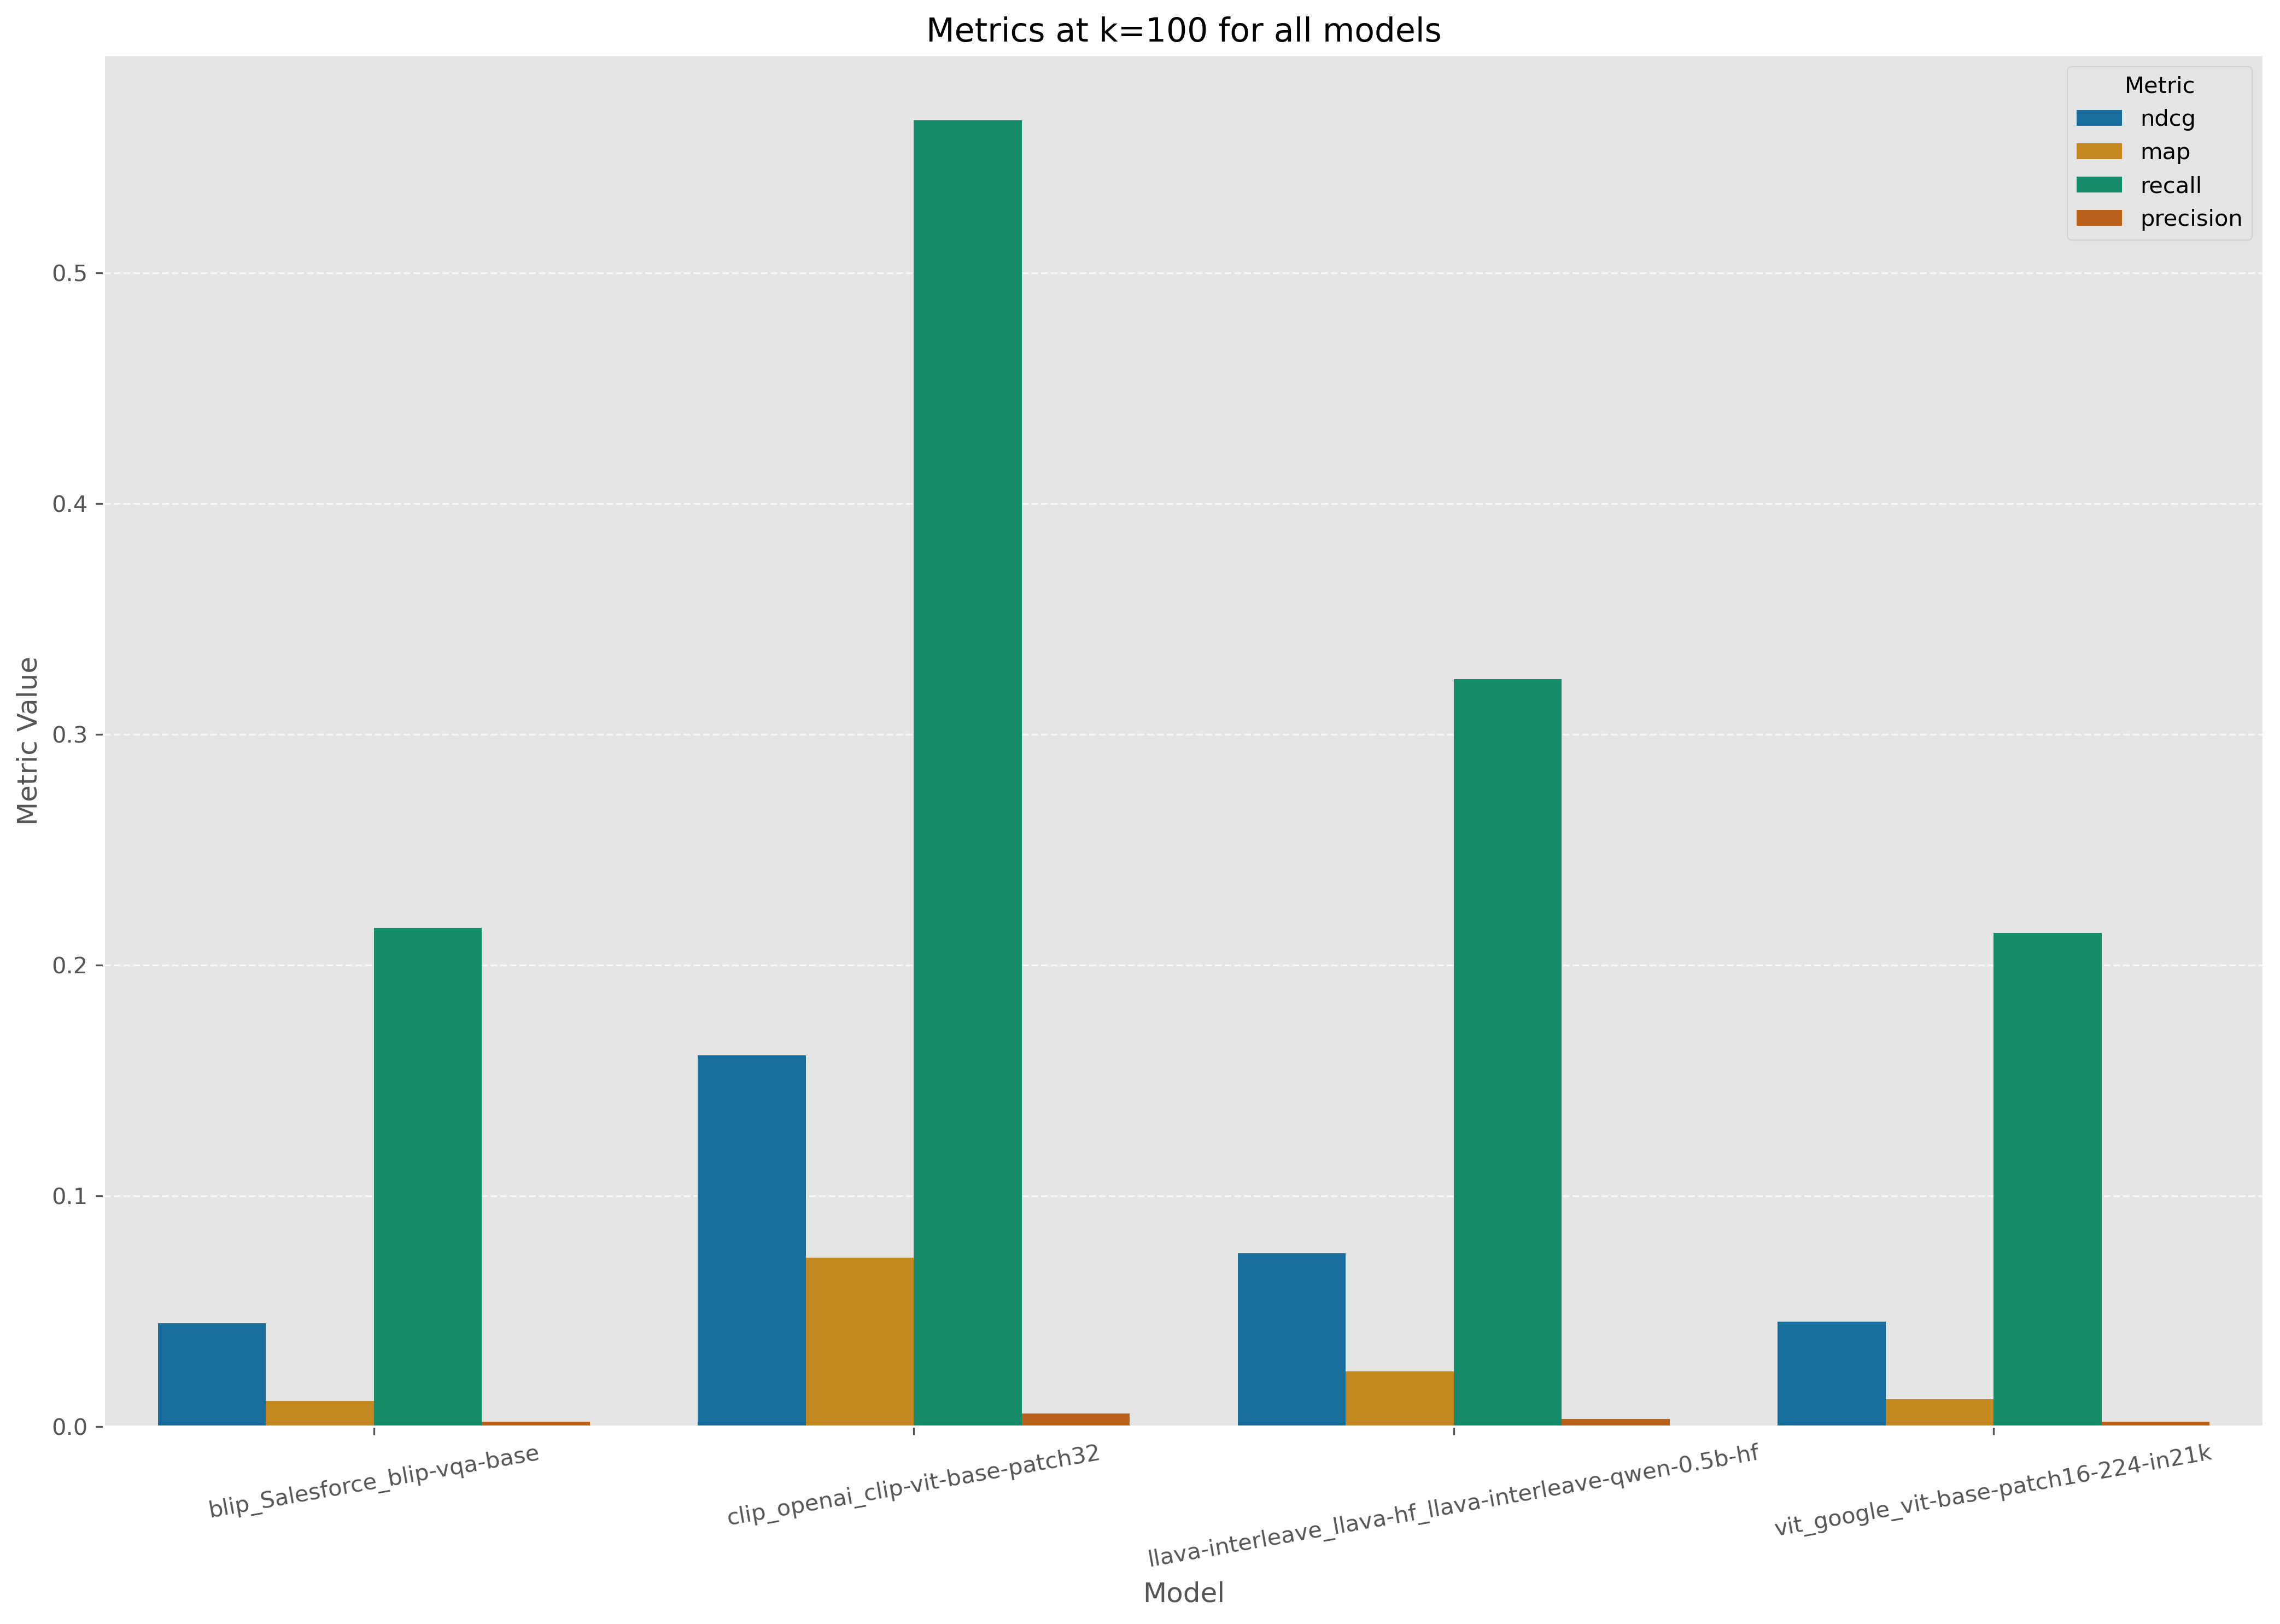

In [36]:
# Compare all metrics at k=10 and k=100
compare_at_k(metrics_df, 10)
compare_at_k(metrics_df, 100)

## Heatmap comparison of models

In [40]:
# Create a pivot table for each metric type
def create_heatmap(df, metric_name):
    # Filter the dataframe for the specific metric
    filtered_df = df[df['Metric'] == metric_name]
    
    # Create pivot table with models as rows and k values as columns
    pivot_df = filtered_df.pivot(index='Model', columns='k', values='Value')
    
    # Plot heatmap
    plt.figure(figsize=(12, len(pivot_df) * 0.8), dpi=300)
    sns.heatmap(pivot_df, annot=True, cmap="YlGnBu", fmt=".4f", linewidths=.5)
    plt.title(f'{metric_name.upper()} across different k values')
    plt.xlabel('k (cutoff)')
    plt.ylabel('Model')
    plt.tight_layout()
    plt.show()

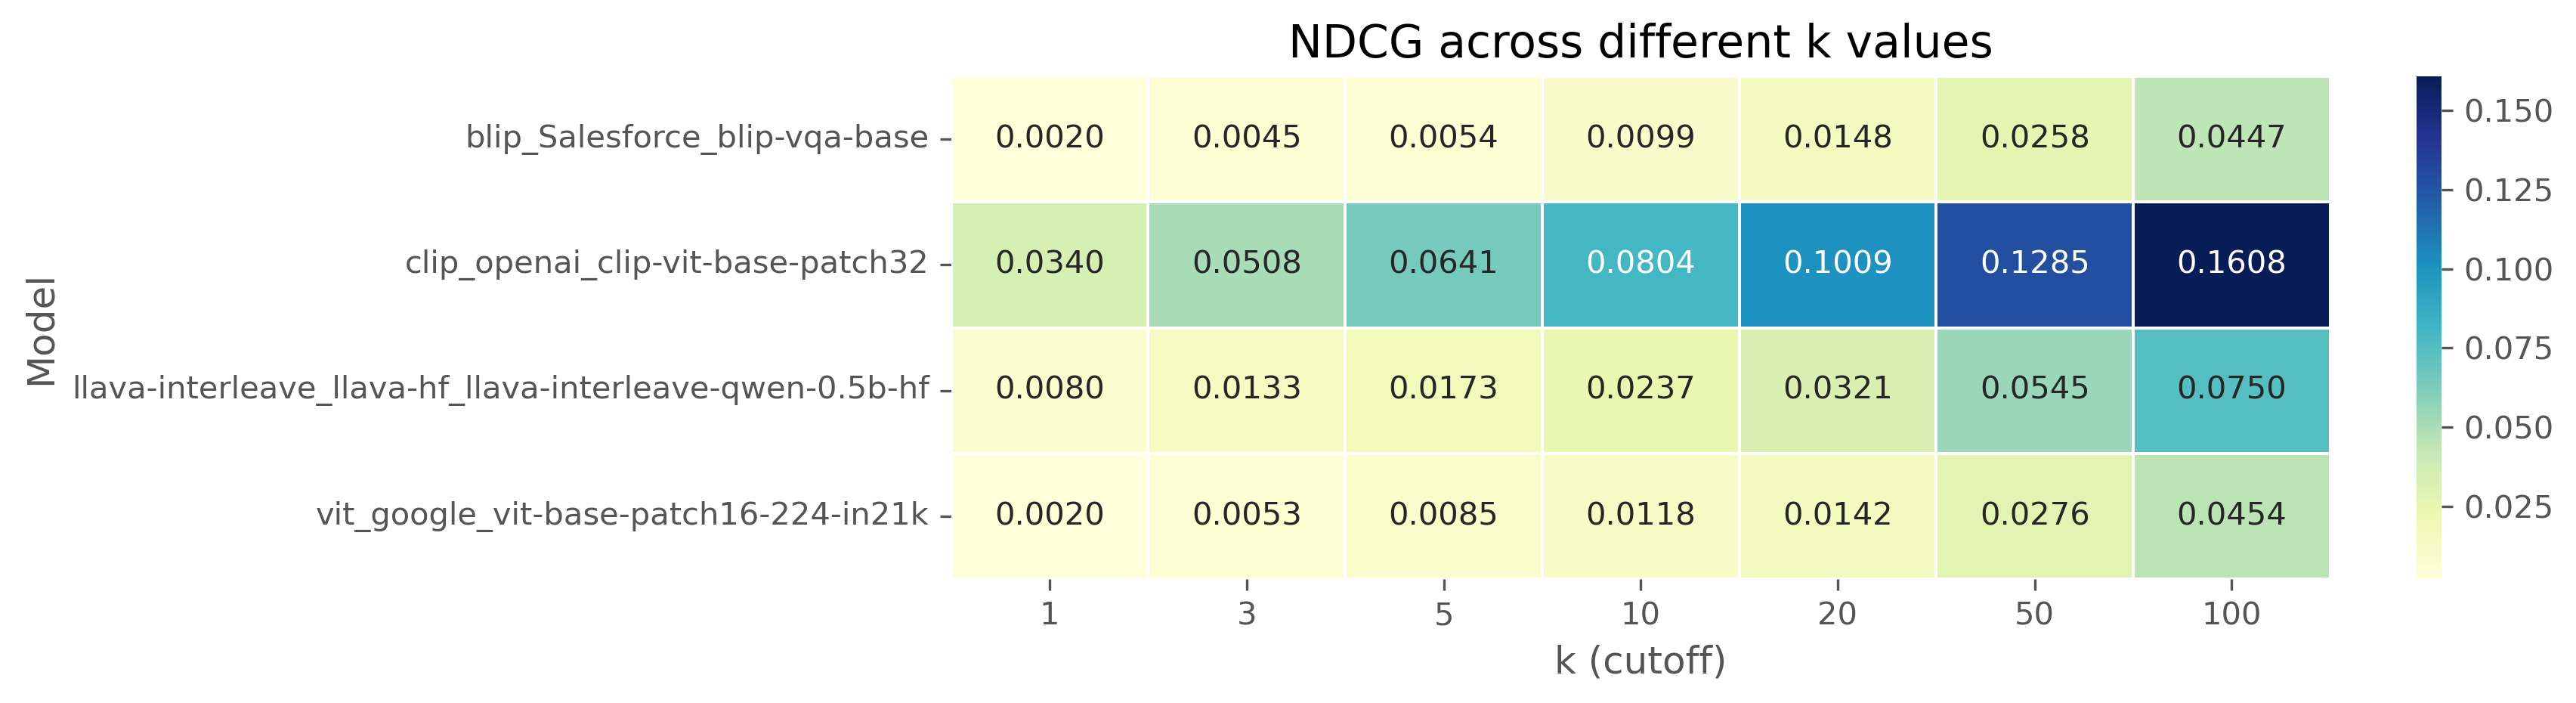

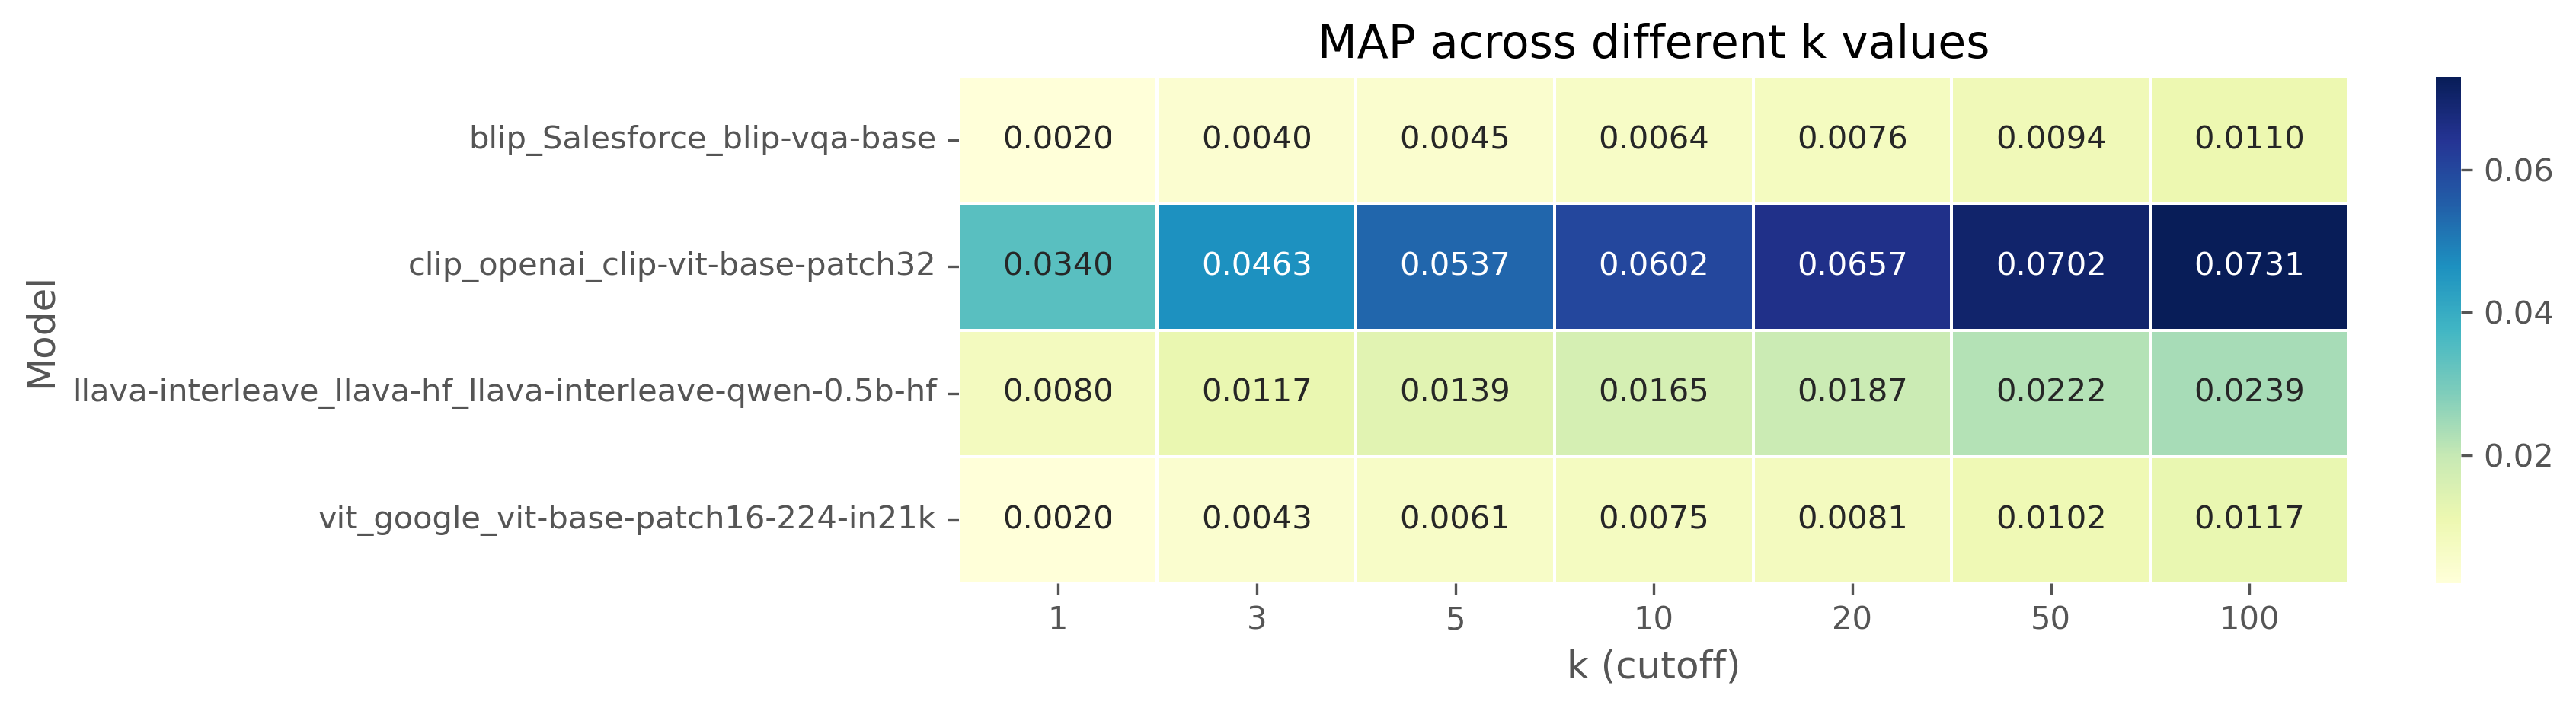

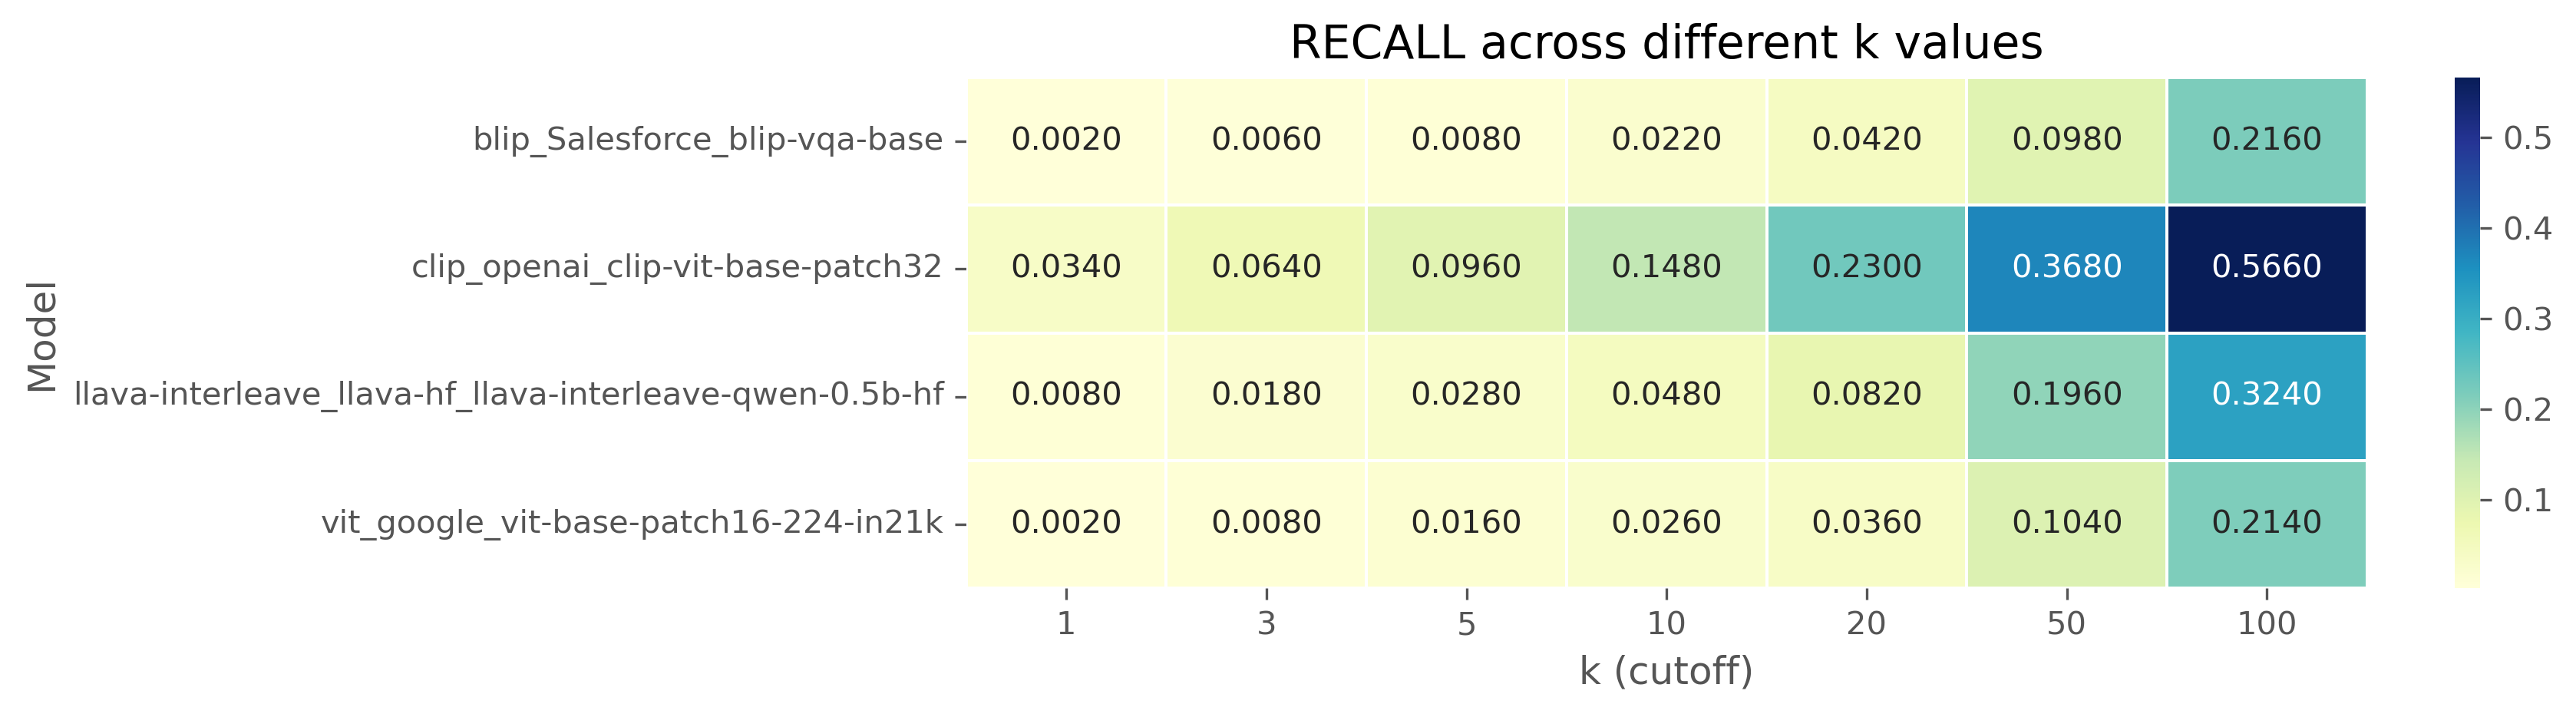

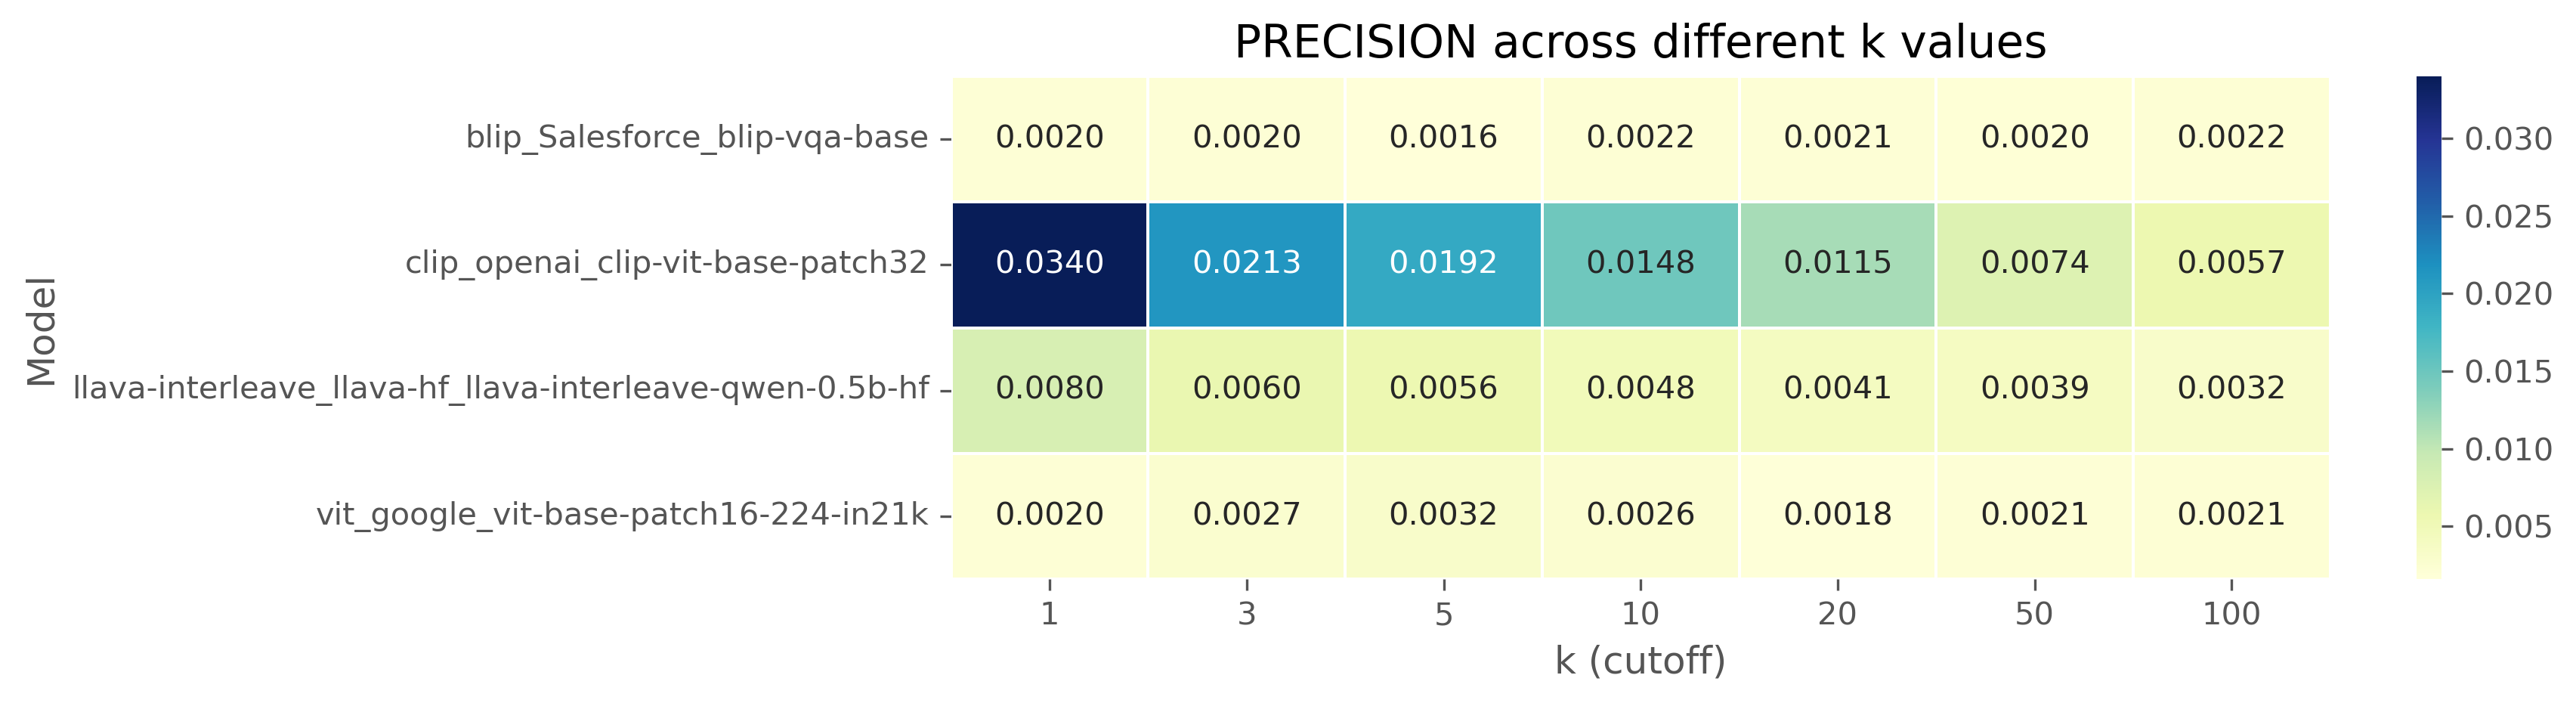

In [41]:
# Create heatmaps for each metric type
for metric in metric_types:
    create_heatmap(metrics_df, metric)

## Performance summary

In [42]:
# Create a summary table of the best performing model for each metric and k value
summary = []

for metric in metric_types:
    for k in k_values:
        filtered = metrics_df[(metrics_df['Metric'] == metric) & (metrics_df['k'] == k)]
        best_model = filtered.loc[filtered['Value'].idxmax()]
        summary.append({
            'Metric': metric,
            'k': k,
            'Best Model': best_model['Model'],
            'Best Value': best_model['Value']
        })

summary_df = pd.DataFrame(summary)
summary_df

,Metric,k,Best Model,Best Value
0,ndcg,1,clip_openai_clip-vit-base-patch32,0.03400
1,ndcg,3,clip_openai_clip-vit-base-patch32,0.05083
2,ndcg,5,clip_openai_clip-vit-base-patch32,0.06409
3,ndcg,10,clip_openai_clip-vit-base-patch32,0.08038
4,ndcg,20,clip_openai_clip-vit-base-patch32,0.10087
5,ndcg,50,clip_openai_clip-vit-base-patch32,0.12849
6,ndcg,100,clip_openai_clip-vit-base-patch32,0.16075
7,map,1,clip_openai_clip-vit-base-patch32,0.03400
8,map,3,clip_openai_clip-vit-base-patch32,0.04633
9,map,5,clip_openai_clip-vit-base-patch32,0.05373


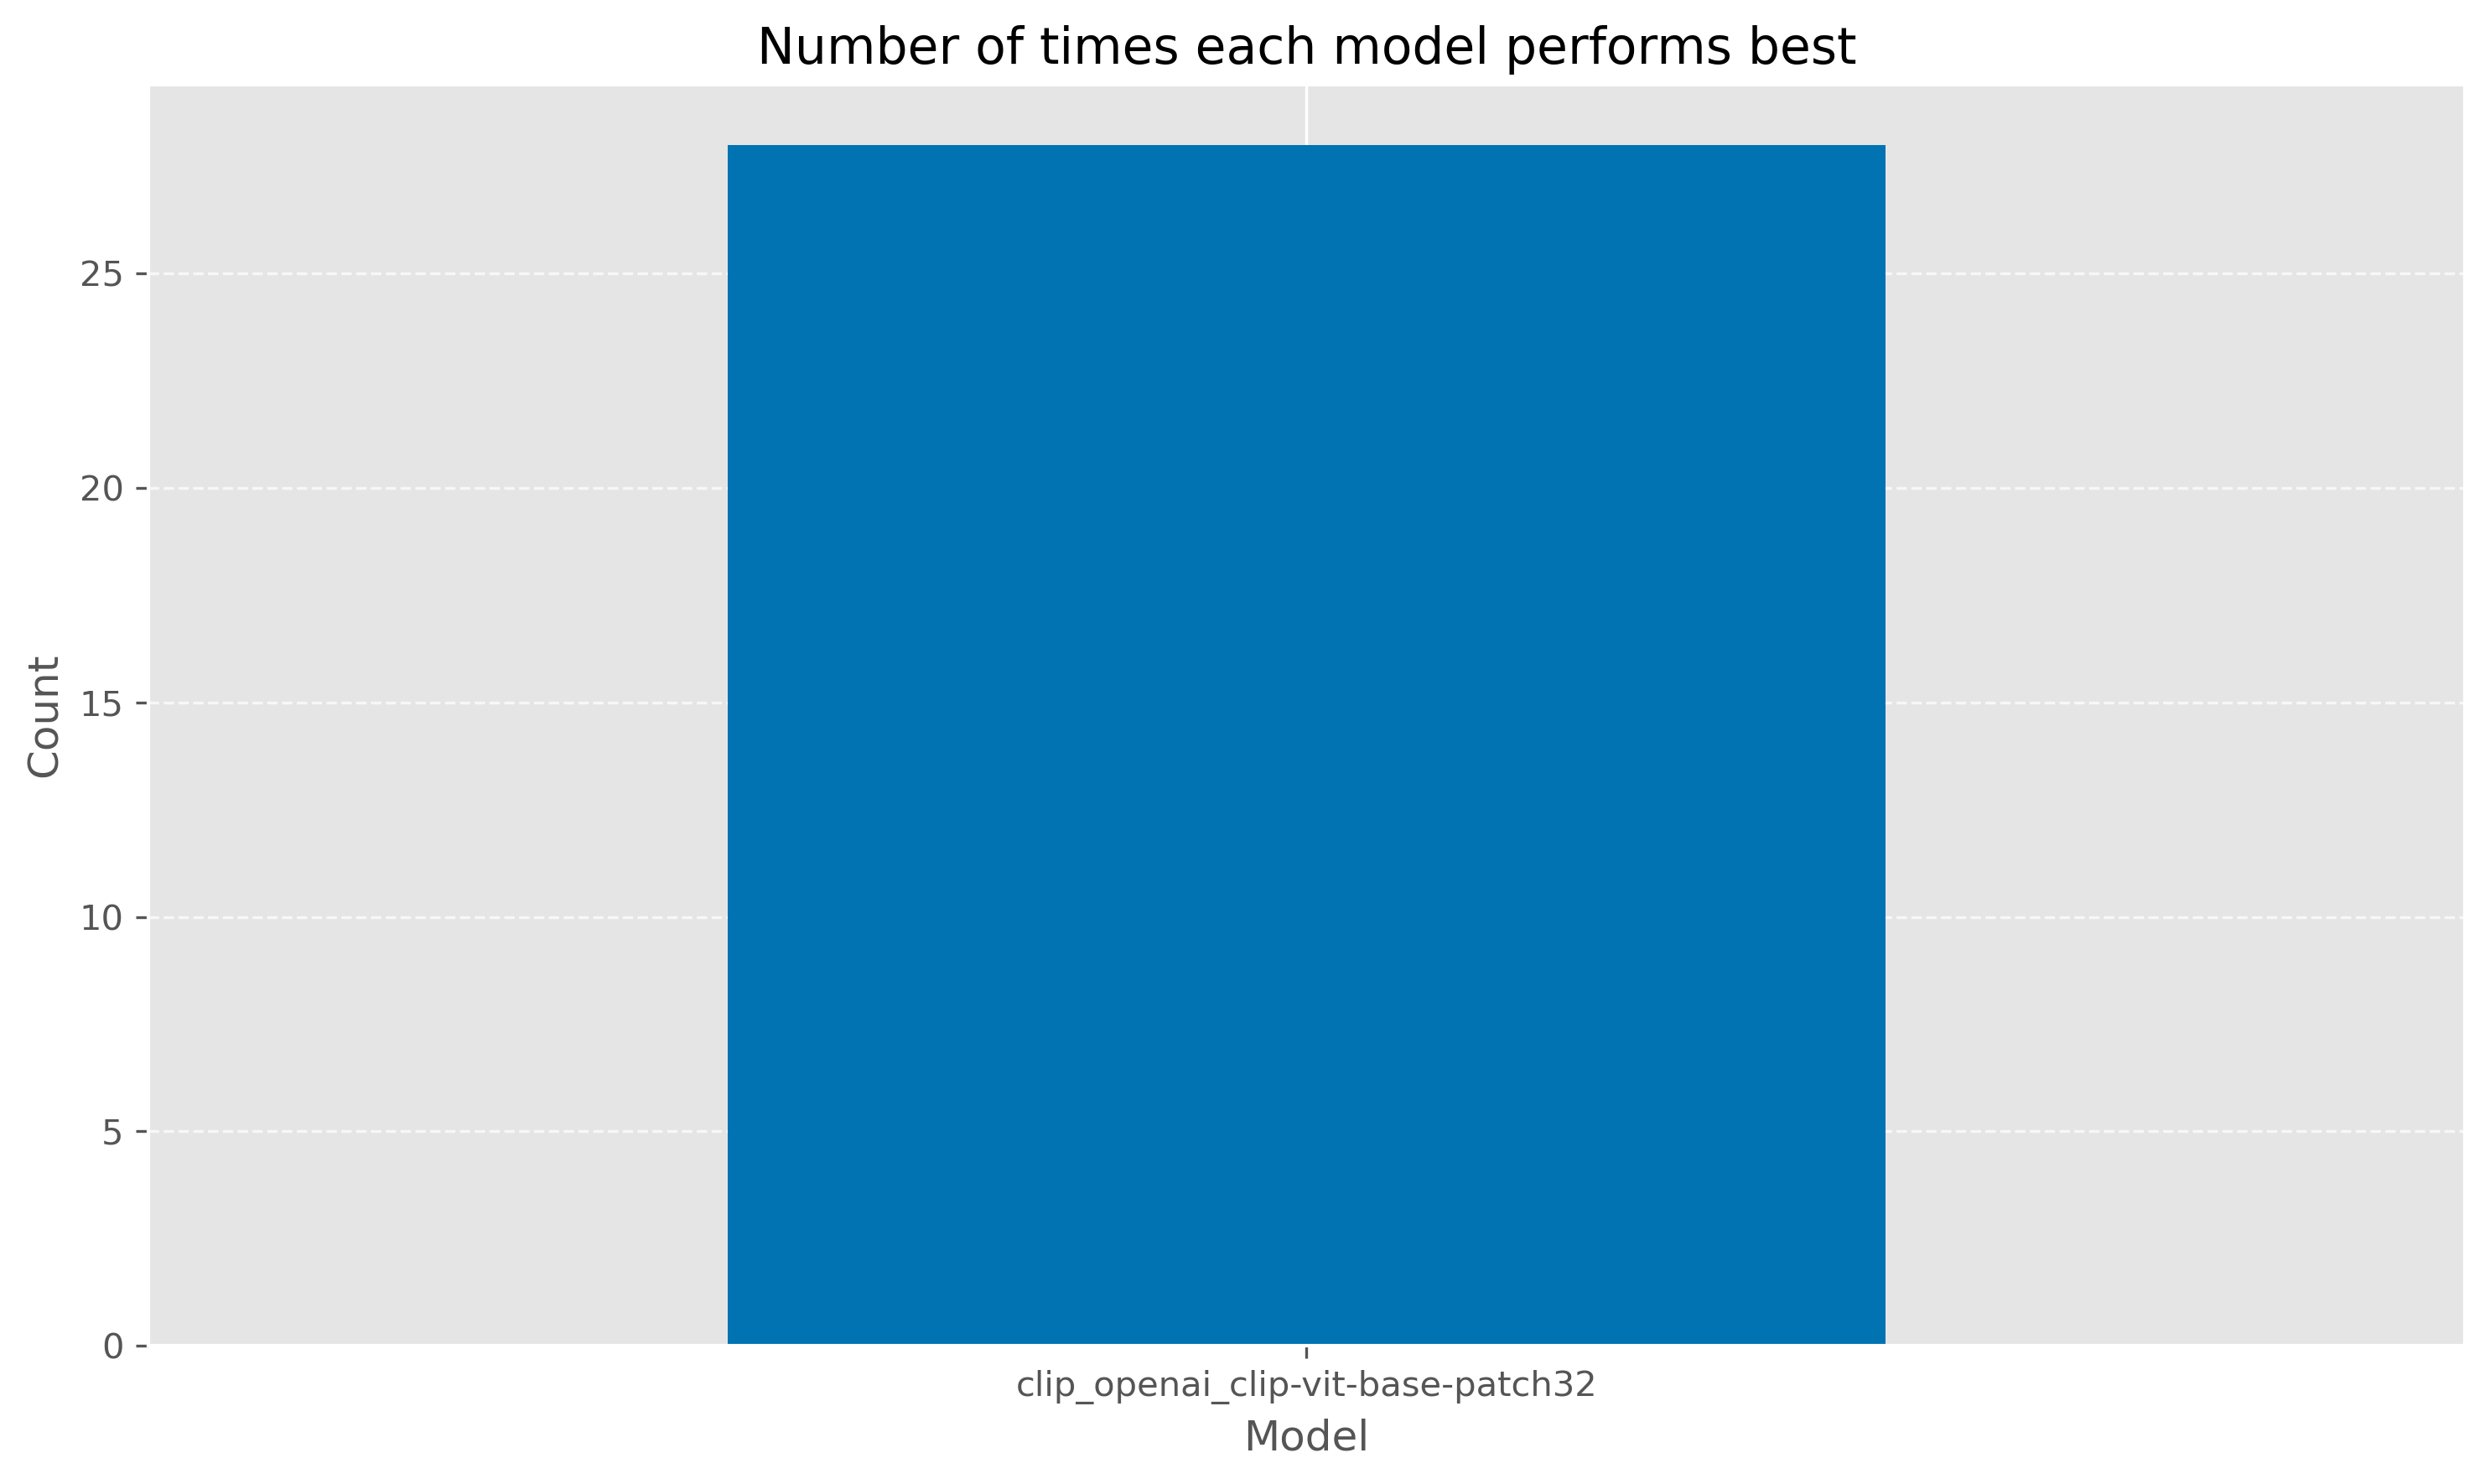

In [48]:
# Count how many times each model is the best
best_model_counts = summary_df['Best Model'].value_counts()

plt.figure(figsize=(10, 6), dpi=300)
best_model_counts.plot(kind='bar')
plt.title('Number of times each model performs best')
plt.xlabel('Model')
plt.ylabel('Count')
plt.xticks(rotation=0, ha='center')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()